In [6]:
%cd 'all_data'

/Users/simranmasand/Downloads/all_data


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
# from google.colab.patches import cv2_imshow
import re
from bs4 import BeautifulSoup #for reading xml file
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS  #for plotting wordcloud
from tqdm import tqdm
from PIL import Image    
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

In [7]:
image_folder = 'train/radiology/images' #path to folder containing images
total_images = len(os.listdir(image_folder))
print('The number of images in data are: %i'%(total_images))

The number of images in data are: 65420


<Figure size 432x288 with 0 Axes>

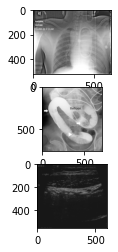

In [8]:
#showing random 3 sample images
np.random.seed(420)
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(3,1) 
window_name = 'image'
for i in range(3): #print 3 sample images
    k = np.random.choice(range(total_images))
    image_file = os.listdir(image_folder)[k]
    image = cv2.imread(os.path.join(image_folder,image_file)) #getting an image file
    axarr[i].imshow(image)  
#     print("\t\t",image_file) #the image file name

In [41]:
cap_train = pd.read_table("train/radiology/traindata.csv",engine="python",encoding="utf8",sep=',', quotechar='"', error_bad_lines=False)
cap_train.head()

<ipython-input-41-cb7f71bc278e>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  cap_train = pd.read_table("train/radiology/traindata.csv",engine="python",encoding="utf8",sep=',', quotechar='"', error_bad_lines=False)


,id,name,caption
0,ROCO_00002,PMC4083729_AMHSR-4-14-g002.jpg,Computed tomography scan in axial view showin...
1,ROCO_00003,PMC2837471_IJD2009-150251.001.jpg,Bacterial contamination occurred after comple...
2,ROCO_00004,PMC2505281_11999_2007_30_Fig6_HTML.jpg,The patient had residual paralysis of the han...
3,ROCO_00005,PMC3745845_IJD2013-683423.005.jpg,Panoramic radiograph after immediate loading.\n
4,ROCO_00007,PMC4917066_amjcaserep-17-301-g001.jpg,Plain abdomen x-ray: Multiple air levels at t...


In [42]:
# cap_train.rename(columns={0:"img",1:"caption"},inplace=True)
# cap_train.head()

In [43]:
cap_train["width"] = ""
cap_train["height"] = ""

In [44]:
image_folder

'train/radiology/images'

In [52]:
for index, row in cap_train.iterrows():
    try:
        row["width"] = np.asarray(Image.open(image_folder+"/"+row["name"])).shape[0]
        row["height"] = np.asarray(Image.open(image_folder+"/"+row["name"])).shape[1]
    except:
        pass

In [34]:
# for img_ in os.listdir(image_folder):
#   # print(img_[:-4])
#   # print(np.asarray(Image.open(image_folder+"/"+img)).shape)
#     try:
#         cap_train.loc[cap_train.img == img_[:-4],"width"] = np.asarray(Image.open(image_folder+"/"+img_)).shape[0]
#         cap_train.loc[cap_train.img == img_[:-4],"height"] = np.asarray(Image.open(image_folder+"/"+img_)).shape[1]
#     except:
#         pass

In [53]:
cap_train.head()

,id,name,caption,width,height
0,ROCO_00002,PMC4083729_AMHSR-4-14-g002.jpg,Computed tomography scan in axial view showin...,704,704
1,ROCO_00003,PMC2837471_IJD2009-150251.001.jpg,Bacterial contamination occurred after comple...,763,745
2,ROCO_00004,PMC2505281_11999_2007_30_Fig6_HTML.jpg,The patient had residual paralysis of the han...,1258,737
3,ROCO_00005,PMC3745845_IJD2013-683423.005.jpg,Panoramic radiograph after immediate loading.\n,325,600
4,ROCO_00007,PMC4917066_amjcaserep-17-301-g001.jpg,Plain abdomen x-ray: Multiple air levels at t...,499,600


<Axes: >

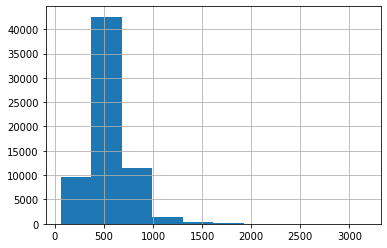

In [54]:
cap_train[cap_train['width']!=""]["width"].hist()

<Axes: >

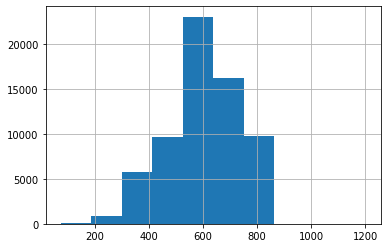

In [55]:
cap_train[cap_train['height']!=""]["height"].hist()

In [60]:
cap_train.caption.value_counts()[:30]

 Initial panoramic radiograph.\n                                                                                                                                              19
 Preoperative radiograph\n                                                                                                                                                    15
 Postoperative radiograph\n                                                                                                                                                   13
 Chest X-ray\n                                                                                                                                                                11
 Final panoramic radiograph.\n                                                                                                                                                11
 Orthopantomogram\n                                                                                                

In [64]:
#adding a new column impression counts which tells the total value counts of impression of that datapoint 
k = cap_train.caption.value_counts()
cap_train = cap_train.merge(k,
         left_on = 'caption',
         right_index=True) #join left impression value with right index

cap_train.columns
     

Index(['caption', 'id', 'name', 'caption_x', 'width', 'height', 'caption_y'], dtype='object')

In [65]:
cap_train.head()

,caption,id,name,caption_x,width,height,caption_y
0,Computed tomography scan in axial view showin...,ROCO_00002,PMC4083729_AMHSR-4-14-g002.jpg,Computed tomography scan in axial view showin...,704,704,1
1,Bacterial contamination occurred after comple...,ROCO_00003,PMC2837471_IJD2009-150251.001.jpg,Bacterial contamination occurred after comple...,763,745,1
2,The patient had residual paralysis of the han...,ROCO_00004,PMC2505281_11999_2007_30_Fig6_HTML.jpg,The patient had residual paralysis of the han...,1258,737,1
3,Panoramic radiograph after immediate loading.\n,ROCO_00005,PMC3745845_IJD2013-683423.005.jpg,Panoramic radiograph after immediate loading.\n,325,600,1
4,Plain abdomen x-ray: Multiple air levels at t...,ROCO_00007,PMC4917066_amjcaserep-17-301-g001.jpg,Plain abdomen x-ray: Multiple air levels at t...,499,600,1


In [66]:
del cap_train['caption_x']

In [70]:
len(cap_train[cap_train['caption_y']>5]['caption'].unique())

19

In [72]:
temp = cap_train.loc[:,'caption'].str.replace(".","").copy() #removing all fullstops and storing the result in a temp variable
words = ""
for i in temp.values:
  k = i.split()
  words+= " ".join(k) + " "
word = words.strip()
wc = WordCloud(width = 1024, height = 720, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 15,).generate(words) 

del k,words,temp

<ipython-input-72-d9d54b211e89>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp = cap_train.loc[:,'caption'].str.replace(".","").copy() #removing all fullstops and storing the result in a temp variable


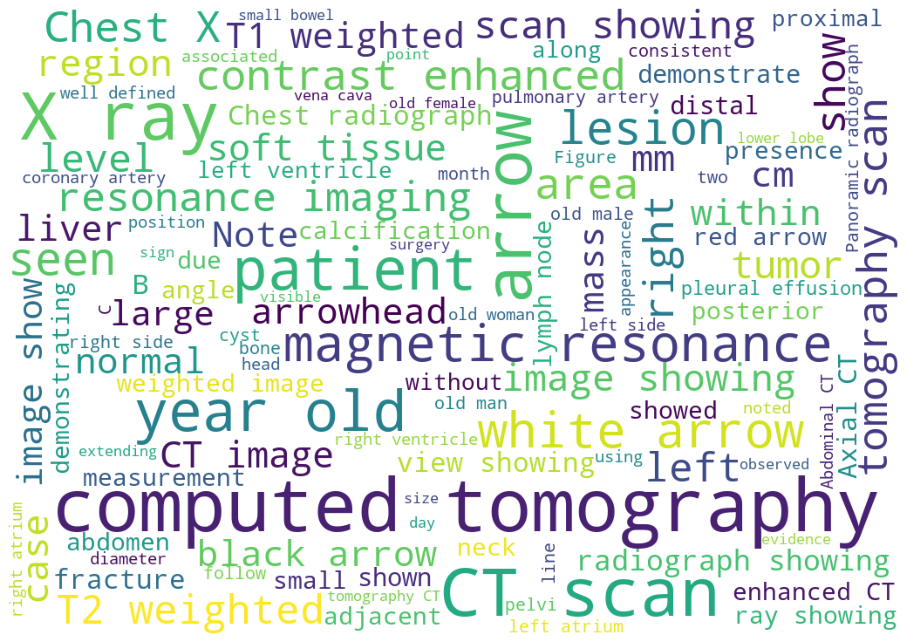

In [73]:
plt.figure(figsize = (16,16))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [76]:
cap_train.to_pickle("total_data.pkl")

In [47]:
cap_train = pd.read_pickle("total_data.pkl")

# Tokenizing data

In [11]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib #for saving model files as pkl files
import os
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
sns.set(palette='muted',style='white')
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu #bleu score
tf.compat.v1.enable_eager_execution()
import os
import math

In [48]:
cap_train["caption_final"] = ' '+cap_train.caption + ' '
cap_train["caption_ip"] = ' ' + cap_train.caption
cap_train["caption_op"] = cap_train.caption + ' '
cap_train.head()

,caption,id,name,width,height,caption_y,caption_final,caption_ip,caption_op
0,Computed tomography scan in axial view showin...,ROCO_00002,PMC4083729_AMHSR-4-14-g002.jpg,704,704,1,Computed tomography scan in axial view showi...,Computed tomography scan in axial view showi...,Computed tomography scan in axial view showin...
1,Bacterial contamination occurred after comple...,ROCO_00003,PMC2837471_IJD2009-150251.001.jpg,763,745,1,Bacterial contamination occurred after compl...,Bacterial contamination occurred after compl...,Bacterial contamination occurred after comple...
2,The patient had residual paralysis of the han...,ROCO_00004,PMC2505281_11999_2007_30_Fig6_HTML.jpg,1258,737,1,The patient had residual paralysis of the ha...,The patient had residual paralysis of the ha...,The patient had residual paralysis of the han...
3,Panoramic radiograph after immediate loading.\n,ROCO_00005,PMC3745845_IJD2013-683423.005.jpg,325,600,1,Panoramic radiograph after immediate loading...,Panoramic radiograph after immediate loading.\n,Panoramic radiograph after immediate loading.\n
4,Plain abdomen x-ray: Multiple air levels at t...,ROCO_00007,PMC4917066_amjcaserep-17-301-g001.jpg,499,600,1,Plain abdomen x-ray: Multiple air levels at ...,Plain abdomen x-ray: Multiple air levels at ...,Plain abdomen x-ray: Multiple air levels at t...


In [49]:
cap_train.drop_duplicates(subset=['caption'],inplace=True)

In [50]:
cap_train.shape

(64772, 9)

In [51]:
cap_train.sort_values(by='caption_y',ascending=False)

,caption,id,name,width,height,caption_y,caption_final,caption_ip,caption_op
2314,Initial panoramic radiograph.\n,ROCO_02908,PMC4347419_dpjo-19-06-00113-gf04.jpg,364,755,19,Initial panoramic radiograph.\n,Initial panoramic radiograph.\n,Initial panoramic radiograph.\n
4756,Preoperative radiograph\n,ROCO_05953,PMC4213876_IJD-5-161-g001.jpg,538,447,15,Preoperative radiograph\n,Preoperative radiograph\n,Preoperative radiograph\n
1223,Postoperative radiograph\n,ROCO_01527,PMC4922229_NJMS-6-180-g006.jpg,587,734,13,Postoperative radiograph\n,Postoperative radiograph\n,Postoperative radiograph\n
6269,Chest X-ray\n,ROCO_07832,PMC2700453_ATM-03-158-g001.jpg,559,743,11,Chest X-ray\n,Chest X-ray\n,Chest X-ray\n
5159,Final panoramic radiograph.\n,ROCO_06465,PMC4944735_2176-9451-dpjo-21-03-00104-gf8.jpg,239,519,11,Final panoramic radiograph.\n,Final panoramic radiograph.\n,Final panoramic radiograph.\n
...,...,...,...,...,...,...,...,...,...
21873,Computed tomographic scan of the abdomen and ...,ROCO_27270,PMC3041052_jls0031026500001.jpg,254,406,1,Computed tomographic scan of the abdomen and...,Computed tomographic scan of the abdomen and...,Computed tomographic scan of the abdomen and ...
21874,Computed tomography scan at the level of the ...,ROCO_27271,PMC2657771_1757-7241-17-5-3.jpg,512,512,1,Computed tomography scan at the level of the...,Computed tomography scan at the level of the...,Computed tomography scan at the level of the ...
21875,Magnetic resonance imaging of the mass\n,ROCO_27272,PMC5558406_TJOD-12-53-g1.jpg,568,450,1,Magnetic resonance imaging of the mass\n,Magnetic resonance imaging of the mass\n,Magnetic resonance imaging of the mass\n
21876,Computed tomography image of the abdominal ao...,ROCO_27273,PMC4928836_pone.0158042.g002.jpg,484,700,1,Computed tomography image of the abdominal a...,Computed tomography image of the abdominal a...,Computed tomography image of the abdominal ao...


In [93]:
cap_train[cap_train['caption_y']>5]

,caption,id,name,width,height,caption_y,caption_final,caption_ip,caption_op
412,Chest radiograph.\n,ROCO_00520,PMC4666442_EDU-0012-2015.01.jpg,634,779,9,Chest radiograph.\n,Chest radiograph.\n,Chest radiograph.\n
1223,Postoperative radiograph\n,ROCO_01527,PMC4922229_NJMS-6-180-g006.jpg,587,734,13,Postoperative radiograph\n,Postoperative radiograph\n,Postoperative radiograph\n
1318,Preoperative panoramic radiograph.\n,ROCO_01658,PMC4331475_CRID2015-267625.001.jpg,575,750,6,Preoperative panoramic radiograph.\n,Preoperative panoramic radiograph.\n,Preoperative panoramic radiograph.\n
1685,Chest X-ray on admission.\n,ROCO_02126,PMC2804722_1757-1626-2-9333-1.jpg,491,600,6,Chest X-ray on admission.\n,Chest X-ray on admission.\n,Chest X-ray on admission.\n
2156,Immediate postoperative radiograph\n,ROCO_02711,PMC4178361_NJMS-5-67-g001.jpg,525,785,6,Immediate postoperative radiograph\n,Immediate postoperative radiograph\n,Immediate postoperative radiograph\n
2314,Initial panoramic radiograph.\n,ROCO_02908,PMC4347419_dpjo-19-06-00113-gf04.jpg,364,755,19,Initial panoramic radiograph.\n,Initial panoramic radiograph.\n,Initial panoramic radiograph.\n
3326,Coronal CT scan of the patient.\n,ROCO_04146,PMC3793112_arh0021200560003.jpg,634,656,7,Coronal CT scan of the patient.\n,Coronal CT scan of the patient.\n,Coronal CT scan of the patient.\n
3547,Abdominal X-ray.\n,ROCO_04432,PMC3234154_ijnrd-4-137f1.jpg,329,406,6,Abdominal X-ray.\n,Abdominal X-ray.\n,Abdominal X-ray.\n
4756,Preoperative radiograph\n,ROCO_05953,PMC4213876_IJD-5-161-g001.jpg,538,447,15,Preoperative radiograph\n,Preoperative radiograph\n,Preoperative radiograph\n
5159,Final panoramic radiograph.\n,ROCO_06465,PMC4944735_2176-9451-dpjo-21-03-00104-gf8.jpg,239,519,11,Final panoramic radiograph.\n,Final panoramic radiograph.\n,Final panoramic radiograph.\n


In [110]:
from sklearn.model_selection import train_test_split
other1 = cap_train[cap_train['caption_y']>5] #selecting those datapoints which have impression valuecounts >5
other2 = cap_train[cap_train['caption_y']<=5] #selecting those datapoints which have impression valuecounts <=5
train,test = train_test_split(other1,test_size = 0.1,random_state = 42)
test_other2_sample = other2.sample(int(0.2*other2.shape[0]),random_state = 42) #getting some datapoints from other2 data for test data
other2 = other2.drop(test_other2_sample.index,axis=0)
#here i will be choosing 0.5 as the test size as to create a reasonable size of test data
test = test.append(test_other2_sample)
test = test.reset_index(drop=True)

train = train.append(other2) 
train = train.reset_index(drop=True)

In [111]:
train.sort_values(by='caption_y',ascending=False)

,caption,id,name,width,height,caption_y,caption_final,caption_ip,caption_op
2,Preoperative radiograph\n,ROCO_05953,PMC4213876_IJD-5-161-g001.jpg,538,447,15,Preoperative radiograph\n,Preoperative radiograph\n,Preoperative radiograph\n
1,Postoperative radiograph\n,ROCO_01527,PMC4922229_NJMS-6-180-g006.jpg,587,734,13,Postoperative radiograph\n,Postoperative radiograph\n,Postoperative radiograph\n
0,Chest X-ray\n,ROCO_07832,PMC2700453_ATM-03-158-g001.jpg,559,743,11,Chest X-ray\n,Chest X-ray\n,Chest X-ray\n
9,Final panoramic radiograph.\n,ROCO_06465,PMC4944735_2176-9451-dpjo-21-03-00104-gf8.jpg,239,519,11,Final panoramic radiograph.\n,Final panoramic radiograph.\n,Final panoramic radiograph.\n
12,Orthopantomogram\n,ROCO_09624,PMC3590735_JISP-16-602-g004.jpg,327,678,10,Orthopantomogram\n,Orthopantomogram\n,Orthopantomogram\n
...,...,...,...,...,...,...,...,...,...
17414,The follow-up barium esophagography shows no ...,ROCO_27219,PMC2810603_ymj-46-859-g005.jpg,401,403,1,The follow-up barium esophagography shows no...,The follow-up barium esophagography shows no...,The follow-up barium esophagography shows no ...
17415,Complete lead fracture. PA chest X-ray of a m...,ROCO_27220,PMC4286824_JCIS-4-74-g020.jpg,533,540,1,Complete lead fracture. PA chest X-ray of a ...,Complete lead fracture. PA chest X-ray of a ...,Complete lead fracture. PA chest X-ray of a m...
17416,CT scan of abdomen showing pneumoperitoneum a...,ROCO_27221,PMC5671692_CRIEM2017-7089573.003.jpg,600,750,1,CT scan of abdomen showing pneumoperitoneum ...,CT scan of abdomen showing pneumoperitoneum ...,CT scan of abdomen showing pneumoperitoneum a...
17417,Cavitary lesion in the left upper lobe\n,ROCO_27222,PMC4629430_Tanaffos-14-149-g001.jpg,356,636,1,Cavitary lesion in the left upper lobe\n,Cavitary lesion in the left upper lobe\n,Cavitary lesion in the left upper lobe\n


In [112]:
from sklearn.utils import resample
df_majority = train[train['caption_y']>=10] #having value counts >=100
df_minority = train[train['caption_y']<=5] #having value counts <=5
df_other = train[(train['caption_y']>5)&(train['caption_y']<15)] #value counts between 5 and 100
n1 = df_minority.shape[0]
n2 = df_majority.shape[0]
n3 = df_other.shape[0]
#we will upsample them to 30
df_minority_upsampled = resample(df_minority,
                                 replace = True,
                                 n_samples = 3*n1,
                                 random_state = 420)
df_majority_downsampled = resample(df_majority,
                                 replace = False,
                                 n_samples = n2//15,
                                 random_state = 420)
df_other_downsampled = resample(df_other,
                                 replace = False,
                                 n_samples = n3//10,
                                 random_state = 420)

train = pd.concat([df_majority_downsampled ,df_minority_upsampled,df_other_downsampled])
train = train.reset_index(drop=True)
# del df_minority_upsampled,df_minority,df_majority,df_other,df_other_downsampled
train.shape

(155410, 9)

In [114]:
test.shape

(12952, 9)

In [115]:
train.to_pickle('train.pkl')
test.to_pickle('test.pkl')

In [9]:
train = pd.read_pickle('train.pkl')
test = pd.read_pickle('test.pkl')

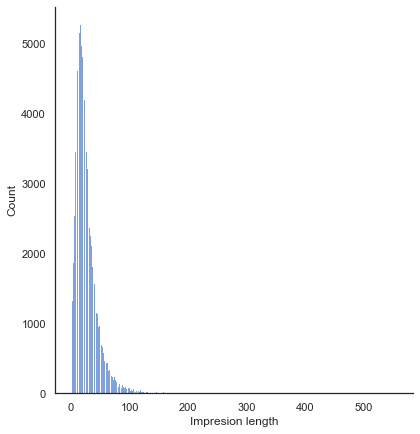


Value Counts for caption length top 5 values

Length|Counts
16    5266
13    5166
15    5147
17    5130
18    4963
dtype: int64

The max and min value of "caption length" was found to be 557 and 1 respectively
The 80 percentile value of caption_len which is 37 will be taken as the maximum padded value for each impression


In [12]:
#tokenizer
tokenizer = Tokenizer(filters = '/n',oov_token = '') #setting filters to none
tokenizer.fit_on_texts(train.caption_final.values)
train_captions = tokenizer.texts_to_sequences(train.caption_final) 
test_captions = tokenizer.texts_to_sequences(test.caption_final) 
vocab_size = len(tokenizer.word_index)
caption_len = np.array([len(i) for i in train_captions])
start_index = tokenizer.word_index[''] #tokened value of 
end_index = tokenizer.word_index[''] #tokened value of 


#visualising impression length and other details
ax = sns.displot(caption_len,height = 6)
ax.set_titles('Value Counts vs Caption Length')
ax.set_xlabels('Impresion length')
plt.show()
print('\nValue Counts for caption length top 5 values\n')
print('Length|Counts')
print(pd.Series(caption_len).value_counts()[:5])
print('\nThe max and min value of "caption length" was found to be %i and %i respectively'%(max(caption_len),min(caption_len)))
print('The 80 percentile value of caption_len which is %i will be taken as the maximum padded value for each impression'%(np.percentile(caption_len,80)))
max_pad = int(np.percentile(caption_len,80))
del train_captions,test_captions #we will create tokenizing  and padding in-built in dataloader
     

# Setting up training schedules

In [13]:
batch_size = 100
embedding_dim = 300
dense_dim = (400,600)
lstm_units = dense_dim
dropout_rate = 0.2

In [65]:
class Dataset():
  #here we will get the images converted to vector form and the corresponding captions
    def __init__(self,df,input_size,tokenizer = tokenizer, augmentation = True,max_pad = max_pad): 
        """
        df  = dataframe containing image_1,image_2 and impression
        """
        self.image1 = df.name
        self.caption = df.caption_ip #inp
        self.caption1 = df.caption_op  #output;
        self.input_size = input_size #tuple ex: (512,512) aiming for 400,600; though 512x512 shall work too
        self.tokenizer = tokenizer
        self.augmentation = augmentation
        self.max_pad = max_pad

        #image augmentation
        #https://imgaug.readthedocs.io/en/latest/source/overview/flip.html?highlight=Fliplr
        self.aug1 = iaa.Fliplr(1) #flip images horizaontally
        self.aug2 = iaa.Flipud(1) #flip images vertically


    def __getitem__(self,i):
        #gets the datapoint at i th index, we will extract the feature vectors of images after resizing the image  and apply augmentation
        image1 = cv2.imread(self.image1[i],cv2.IMREAD_UNCHANGED)/255 
        image1 = cv2.resize(image1,self.input_size,interpolation = cv2.INTER_NEAREST)
        if image1.any()==None:
            print("%i , %s image sent null value"%(i,self.image1[i]))


        #tokenizing and padding
        caption = self.tokenizer.texts_to_sequences(self.caption[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

        caption = pad_sequences(caption,maxlen = self.max_pad,padding = 'post') #opshape:(input_length,)
        caption = tf.squeeze(caption,axis=0) #opshape = (input_length,) removing unwanted axis if present

        caption1 = self.tokenizer.texts_to_sequences(self.caption1[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

        caption1 = pad_sequences(caption1,maxlen = self.max_pad,padding = 'post') #opshape: (input_length,)
        caption1 = tf.squeeze(caption1,axis=0) #opshape = (input_length,) removing unwanted axis if present




        if self.augmentation: #we will not apply augmentation that crops the image 
            a = np.random.uniform()
            if a<0.333:
                image1 = self.aug1.augment_image(image1)
            elif a<0.667:
                image1 = self.aug2.augment_image(image1)
            else: #applying no augmentation
                pass;


        return image1,caption,caption1

    
    def __len__(self):
        return len(self.image1)


class Dataloader(tf.keras.utils.Sequence):     #for batching
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        indexes = [self.indexes[j] for j in range(start,stop)] #getting the shuffled index values
        data = [self.dataset[j] for j in indexes] #taken from Data class (calls __getitem__ of Data) here the shape is batch_size*3, (image_1,image_2,caption)
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)] #here the shape will become batch_size*input_size(of image)*3,batch_size*input_size(of image)*3
                                                                      #,batch_size*1*max_pad


        return tuple([[batch[0],batch[1],batch[2]]]) #here [image1,image2, caption(without )],caption(without ) (op)
    
    def __len__(self): #returns total number of batches in an epoch
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self): #it runs at the end of epoch
        if self.shuffle:
            np.random.shuffle(self.indexes) #in-place shuffling takes place

In [66]:
input_size = (400,600)
train_dataloader = Dataset(train,input_size)
# train_dataloader = Dataloader(train_dataloader,batch_size = batch_size)

# test_dataloader = Dataset(test,input_size)
# test_dataloader = Dataloader(test_dataloader,batch_size = batch_size)


In [77]:
%ls

test/           total_data.pkl  train.pkl
test.pkl        train/          validation/


In [75]:
cv2.imshow(cv2.imread(train_dataloader.image1[0]))

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)


In [1]:
import torch
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel


In [2]:
torch.__version__

'2.0.1'

In [3]:

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

In [42]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

# conditional image captioning
text = "a photography of"
inputs = processor(raw_image, text, return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))
# >>> a photography of a woman and her dog

# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))


a photography of a woman and her dog on the beach
a woman sitting on the beach with her dog


 Sagittal T1-weighted magnetic resonance image four weeks after the endoscopic third ventriculostomy. Demonstrates unchanged ventricular size despite patent ventriculostomy



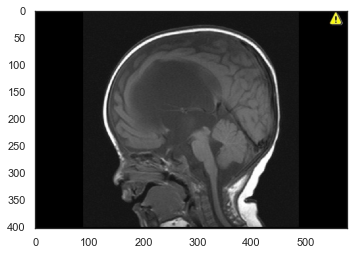

In [29]:
print(train.iloc[0]["caption"])

plt.imshow(plt.imread(image_folder+"/"+train.iloc[0]["name"]))

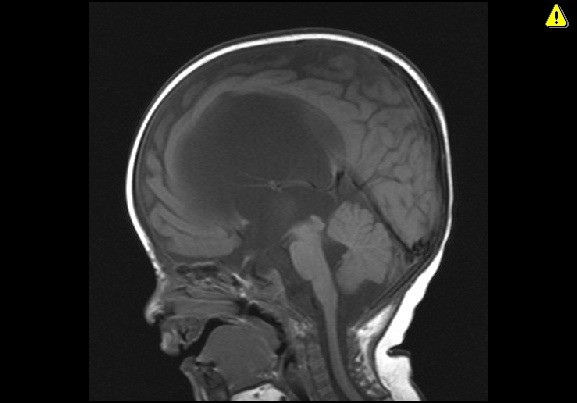

In [44]:
image_ex = Image.open(image_folder+"/"+train.iloc[0]["name"])
image_ex
# model.encode_image(image = Image.open(image_folder+"/"+train.iloc[0]["name"]))

In [45]:
inputs = processor(image_ex, return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

the brain is shown in this mri mri mri mri mri mri mri mri mri mri mri mri mri


In [46]:
train

,caption,id,name,width,height,caption_y,caption_final,caption_ip,caption_op
0,Sagittal T1-weighted magnetic resonance image...,ROCO_17530,PMC3443652_1752-1947-6-222-2.jpg,403,577,1,Sagittal T1-weighted magnetic resonance imag...,Sagittal T1-weighted magnetic resonance imag...,Sagittal T1-weighted magnetic resonance image...
1,Computed tomography scan demonstrating a righ...,ROCO_33013,PMC4298933_LI-32-87-g001.jpg,463,576,1,Computed tomography scan demonstrating a rig...,Computed tomography scan demonstrating a rig...,Computed tomography scan demonstrating a righ...
2,Computed tomographic angiogram of the patient...,ROCO_74213,PMC4887620_CRIS2016-1375214.003.jpg,867,519,1,Computed tomographic angiogram of the patien...,Computed tomographic angiogram of the patien...,Computed tomographic angiogram of the patient...
3,An intact 26-month graft.\n,ROCO_01928,PMC4186304_gox-1-e76-g010.jpg,1156,800,1,An intact 26-month graft.\n,An intact 26-month graft.\n,An intact 26-month graft.\n
4,Real time MR temperature monitoring in the ab...,ROCO_16297,PMC4250033_poljradiol-79-439-g002.jpg,573,600,1,Real time MR temperature monitoring in the a...,Real time MR temperature monitoring in the a...,Real time MR temperature monitoring in the ab...
...,...,...,...,...,...,...,...,...,...
155405,Panorex view of the mandible\n,ROCO_38974,PMC4090976_JSTCR-6-21-g003.jpg,306,555,1,Panorex view of the mandible\n,Panorex view of the mandible\n,Panorex view of the mandible\n
155406,Imaging characteristics from lung CT. A 46-ye...,ROCO_21082,PMC5463395_13054_2017_1731_Fig1_HTML.jpg,264,358,1,Imaging characteristics from lung CT. A 46-y...,Imaging characteristics from lung CT. A 46-y...,Imaging characteristics from lung CT. A 46-ye...
155407,Follow-up panoramic radiograph depicting erup...,ROCO_58556,PMC4771879_CRID2016-9750947.009.jpg,402,750,1,Follow-up panoramic radiograph depicting eru...,Follow-up panoramic radiograph depicting eru...,Follow-up panoramic radiograph depicting erup...
155408,Radiographs show healing of the fracture at 5...,ROCO_00459,PMC4109381_1471-2474-15-225-4.jpg,751,600,1,Radiographs show healing of the fracture at ...,Radiographs show healing of the fracture at ...,Radiographs show healing of the fracture at 5...


In [83]:
from datasets import load_dataset
from datasets import load_from_disk

In [86]:
train_data = load_from_disk('datasets/train')

In [111]:
train_data

Dataset({
    features: ['image', 'Unnamed: 0', 'id', 'caption'],
    num_rows: 65420
})

In [93]:
val_data = load_from_disk('datasets/val')
test_data = load_from_disk('datasets/test')

In [112]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["caption"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [113]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base")

In [114]:
train_dataset = ImageCaptioningDataset(train_data, processor)

In [115]:
item = train_dataset[0]
for k,v in item.items():
    print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


In [151]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1)

In [152]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

input_ids torch.Size([1, 512])
attention_mask torch.Size([1, 512])
pixel_values torch.Size([1, 3, 224, 224])


In [153]:
processor.decode(batch["input_ids"][0])

'[CLS] spinal canal narrowing at c2, c3, c4 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

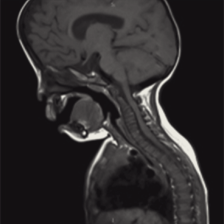

In [154]:
MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [122]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

In [155]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(0.1055, grad_fn=<NllLossBackward0>)

In [ ]:
from tqdm import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in tqdm(range(50)):
    running_loss = 0.0
    print("Epoch:", epoch)
    for idx, batch in tqdm(enumerate(train_dataloader)):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)

        loss = outputs.loss
        running_loss += loss.item()
        if idx % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

#         print("Loss:", loss.item())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0



0it [00:00, ?it/s]
1it [00:03,  3.61s/it]
2it [00:06,  3.21s/it]
3it [00:08,  2.48s/it]
4it [00:10,  2.32s/it]
5it [00:13,  2.60s/it]
6it [00:16,  2.91s/it]
7it [00:18,  2.41s/it]
8it [00:19,  2.05s/it]
9it [00:20,  1.79s/it]
10it [00:22,  1.65s/it]
11it [00:23,  1.68s/it]
12it [00:25,  1.65s/it]
13it [00:26,  1.53s/it]
14it [00:27,  1.44s/it]
15it [00:29,  1.37s/it]
16it [00:30,  1.33s/it]
17it [00:32,  1.45s/it]
18it [00:33,  1.54s/it]
19it [00:35,  1.51s/it]
20it [00:36,  1.50s/it]
21it [00:38,  1.54s/it]
22it [00:39,  1.50s/it]
23it [00:41,  1.44s/it]
24it [00:42,  1.38s/it]
25it [00:43,  1.47s/it]
26it [00:45,  1.51s/it]
27it [00:46,  1.43s/it]
28it [00:48,  1.38s/it]
29it [00:49,  1.39s/it]
30it [00:50,  1.34s/it]
31it [00:52,  1.44s/it]
32it [00:53,  1.44s/it]
33it [00:55,  1.40s/it]
34it [00:56,  1.43s/it]
35it [00:58,  1.47s/it]
36it [00:59,  1.45s/it]
37it [01:00,  1.43s/it]
38it [01:02,  1.38s/it]
39it [01:03,  1.41s/it]
40it [01:05,  1.49s/it]
41it [01:06,  1.44s/it]
42it 

588it [26:32,  2.43s/it]
589it [26:34,  2.19s/it]
590it [26:37,  2.45s/it]
591it [26:38,  2.19s/it]
592it [26:40,  1.95s/it]
593it [26:41,  1.83s/it]
594it [26:43,  1.82s/it]
595it [26:45,  1.76s/it]
596it [26:48,  2.36s/it]
597it [26:52,  2.63s/it]
598it [26:53,  2.22s/it]
599it [26:54,  1.97s/it]
600it [26:56,  1.74s/it]
601it [26:57,  1.67s/it]
602it [26:59,  1.74s/it]
603it [27:01,  1.72s/it]
604it [27:02,  1.61s/it]
605it [27:03,  1.49s/it]
606it [27:05,  1.45s/it]
607it [27:06,  1.38s/it]
608it [27:07,  1.42s/it]
609it [27:09,  1.38s/it]
610it [27:10,  1.34s/it]
611it [27:11,  1.35s/it]
612it [27:12,  1.32s/it]
613it [27:14,  1.28s/it]
614it [27:15,  1.29s/it]
615it [27:16,  1.28s/it]
616it [27:18,  1.46s/it]
617it [27:20,  1.50s/it]
618it [27:21,  1.46s/it]
619it [27:22,  1.39s/it]
620it [27:24,  1.37s/it]
621it [27:25,  1.44s/it]
622it [27:27,  1.43s/it]
623it [27:28,  1.43s/it]
624it [27:29,  1.44s/it]
625it [27:31,  1.44s/it]
626it [27:32,  1.45s/it]
627it [27:34,  1.47s/it]


1162it [1:04:24,  4.65s/it]
1163it [1:04:29,  4.72s/it]
1164it [1:04:34,  4.84s/it]
1165it [1:04:39,  4.75s/it]
1166it [1:04:44,  4.84s/it]
1167it [1:04:48,  4.74s/it]
1168it [1:04:54,  4.84s/it]
1169it [1:04:58,  4.69s/it]
1170it [1:05:03,  4.70s/it]
1171it [1:05:07,  4.63s/it]
1172it [1:05:12,  4.68s/it]
1173it [1:05:18,  5.22s/it]
1174it [1:05:24,  5.22s/it]
1175it [1:07:36, 43.47s/it]
1176it [1:07:42, 32.10s/it]
1177it [1:07:47, 24.00s/it]
1178it [1:07:54, 18.96s/it]
1179it [1:08:00, 14.92s/it]
1180it [1:08:07, 12.55s/it]
1181it [1:08:11, 10.15s/it]
1182it [1:08:16,  8.46s/it]
1183it [1:08:20,  7.30s/it]
1184it [1:08:26,  6.94s/it]
1185it [1:08:33,  6.93s/it]
1186it [1:08:39,  6.41s/it]
1187it [1:08:44,  5.99s/it]
1188it [1:08:48,  5.61s/it]
1189it [1:08:53,  5.20s/it]
1190it [1:08:57,  5.00s/it]
1191it [1:09:02,  4.95s/it]
1192it [1:09:07,  5.05s/it]
1193it [1:09:12,  4.86s/it]
1194it [1:09:16,  4.78s/it]
1195it [1:09:22,  5.04s/it]
1196it [1:09:27,  4.99s/it]
1197it [1:09:32,  5.

1690it [1:53:08,  5.07s/it]
1691it [1:53:15,  5.47s/it]
1692it [1:53:20,  5.28s/it]
1693it [1:53:25,  5.36s/it]
1694it [1:53:30,  5.25s/it]
1695it [1:53:36,  5.46s/it]
1696it [1:53:42,  5.51s/it]
1697it [1:53:47,  5.44s/it]
1698it [1:53:53,  5.53s/it]
1699it [1:53:58,  5.47s/it]
1700it [1:54:03,  5.36s/it]
1701it [1:54:08,  5.17s/it]
1702it [1:54:13,  5.13s/it]
1703it [1:54:18,  5.13s/it]
1704it [1:54:22,  4.88s/it]
1705it [1:54:29,  5.39s/it]
1706it [1:54:34,  5.32s/it]
1707it [1:54:40,  5.43s/it]
1708it [1:54:45,  5.31s/it]
1709it [1:54:49,  4.94s/it]
1710it [1:54:54,  4.91s/it]
1711it [1:54:59,  4.93s/it]
1712it [1:55:04,  4.90s/it]
1713it [1:55:08,  4.78s/it]
1714it [1:55:13,  4.80s/it]
1715it [1:55:18,  4.89s/it]
1716it [1:55:23,  4.84s/it]
1717it [1:55:28,  4.82s/it]
1718it [1:55:32,  4.79s/it]
1719it [1:55:38,  4.98s/it]
1720it [1:55:42,  4.84s/it]
1721it [1:55:45,  4.19s/it]
1722it [1:55:50,  4.54s/it]
1723it [1:55:56,  4.88s/it]
1724it [1:56:00,  4.67s/it]
1725it [1:56:04,  4.

[1,     3] loss: 0.290



2000it [2:18:04,  4.73s/it]
2001it [2:18:09,  4.76s/it]
2002it [2:18:13,  4.66s/it]
2003it [2:18:18,  4.63s/it]
2004it [2:18:23,  4.58s/it]
2005it [2:18:27,  4.63s/it]
2006it [2:18:31,  4.46s/it]
2007it [2:18:37,  4.72s/it]
2008it [2:18:42,  4.84s/it]
2009it [2:18:46,  4.74s/it]
2010it [2:18:51,  4.78s/it]
2011it [2:18:56,  4.70s/it]
2012it [2:19:00,  4.64s/it]
2013it [2:19:05,  4.76s/it]
2014it [2:19:10,  4.74s/it]
2015it [2:19:14,  4.55s/it]
2016it [2:19:19,  4.62s/it]
2017it [2:19:24,  4.78s/it]
2018it [2:19:29,  4.74s/it]
2019it [2:19:33,  4.71s/it]
2020it [2:19:38,  4.72s/it]
2021it [2:19:41,  4.26s/it]
2022it [2:19:46,  4.53s/it]
2023it [2:19:49,  4.10s/it]
2024it [2:19:54,  4.35s/it]
2025it [2:19:59,  4.51s/it]
2026it [2:20:04,  4.48s/it]
2027it [2:20:08,  4.38s/it]
2028it [2:20:13,  4.66s/it]
2029it [2:20:18,  4.87s/it]
2030it [2:20:23,  4.84s/it]
2031it [2:20:28,  4.76s/it]
2032it [2:20:33,  4.81s/it]
2033it [2:20:37,  4.75s/it]
2034it [2:20:42,  4.67s/it]
2035it [2:20:44,  3

2528it [3:00:19,  5.12s/it]
2529it [3:00:24,  5.02s/it]
2530it [3:00:29,  4.98s/it]
2531it [3:00:33,  4.89s/it]
2532it [3:00:38,  4.94s/it]
2533it [3:00:43,  4.88s/it]
2534it [3:00:48,  4.85s/it]
2535it [3:00:53,  4.82s/it]
2536it [3:00:58,  4.91s/it]
2537it [3:01:03,  5.03s/it]
2538it [3:01:08,  4.97s/it]
2539it [3:01:13,  4.92s/it]
2540it [3:01:17,  4.85s/it]
2541it [3:01:23,  5.11s/it]
2542it [3:01:28,  5.16s/it]
2543it [3:01:34,  5.45s/it]
2544it [3:01:39,  5.32s/it]
2545it [3:01:44,  5.10s/it]
2546it [3:01:50,  5.21s/it]
2547it [3:01:55,  5.18s/it]
2548it [3:01:59,  5.01s/it]
2549it [3:02:04,  5.08s/it]
2550it [3:02:10,  5.24s/it]
2551it [3:02:17,  5.60s/it]
2552it [3:02:23,  5.75s/it]
2553it [3:02:33,  7.08s/it]
2554it [3:02:40,  7.24s/it]
2555it [3:02:47,  6.92s/it]
2556it [3:02:52,  6.42s/it]
2557it [3:02:58,  6.26s/it]
2558it [3:03:03,  6.01s/it]
2559it [3:03:09,  6.06s/it]
2560it [3:19:18, 294.87s/it]
2561it [3:19:24, 208.16s/it]
2562it [3:19:30, 147.50s/it]
2563it [3:19:35, 

3055it [4:56:30,  5.65s/it]
3056it [4:56:35,  5.54s/it]
3057it [4:56:41,  5.61s/it]
3058it [4:56:47,  5.77s/it]
3059it [4:56:54,  6.22s/it]
3060it [4:57:00,  6.03s/it]
3061it [4:57:06,  6.21s/it]
3062it [4:57:12,  6.15s/it]
3063it [4:57:18,  6.05s/it]
3064it [4:57:24,  5.88s/it]
3065it [4:57:30,  6.11s/it]
3066it [4:57:36,  6.04s/it]
3067it [4:57:43,  6.23s/it]
3068it [4:57:48,  5.95s/it]
3069it [4:57:54,  6.02s/it]
3070it [4:58:01,  6.12s/it]
3071it [4:58:06,  5.99s/it]
3072it [4:58:13,  6.06s/it]
3073it [4:58:18,  5.88s/it]
3074it [4:58:24,  5.83s/it]
3075it [4:58:29,  5.60s/it]
3076it [4:58:34,  5.35s/it]
3077it [4:58:39,  5.26s/it]
3078it [4:58:43,  5.08s/it]
3079it [4:58:48,  5.10s/it]
3080it [4:58:54,  5.39s/it]
3081it [4:59:00,  5.40s/it]
3082it [4:59:07,  5.89s/it]
3083it [4:59:13,  6.08s/it]
3084it [4:59:20,  6.27s/it]
3085it [4:59:27,  6.33s/it]
3086it [4:59:32,  6.12s/it]
3087it [4:59:38,  6.01s/it]
3088it [4:59:44,  6.00s/it]
3089it [4:59:50,  6.06s/it]
3090it [4:59:55,  5.

3583it [5:45:47,  4.95s/it]
3584it [5:45:52,  4.98s/it]
3585it [5:45:58,  5.23s/it]
3586it [5:46:03,  5.14s/it]
3587it [5:46:08,  5.09s/it]
3588it [5:46:14,  5.37s/it]
3589it [5:46:19,  5.33s/it]
3590it [5:46:25,  5.52s/it]
3591it [5:46:30,  5.43s/it]
3592it [5:46:36,  5.46s/it]
3593it [5:46:41,  5.41s/it]
3594it [5:46:46,  5.27s/it]
3595it [5:46:51,  5.02s/it]
3596it [5:46:56,  5.16s/it]
3597it [5:47:03,  5.54s/it]
3598it [5:47:08,  5.66s/it]
3599it [5:47:15,  5.80s/it]
3600it [5:47:20,  5.58s/it]
3601it [5:47:25,  5.37s/it]
3602it [5:47:29,  5.21s/it]
3603it [5:47:35,  5.23s/it]
3604it [5:47:40,  5.19s/it]
3605it [5:47:45,  5.07s/it]
3606it [5:47:50,  5.07s/it]
3607it [5:47:54,  4.94s/it]
3608it [5:48:00,  5.08s/it]
3609it [5:48:06,  5.51s/it]
3610it [5:48:13,  5.79s/it]
3611it [5:48:18,  5.65s/it]
3612it [5:48:23,  5.38s/it]
3613it [5:48:27,  5.11s/it]
3614it [5:48:34,  5.48s/it]
3615it [5:48:39,  5.46s/it]
3616it [5:48:44,  5.46s/it]
3617it [5:48:50,  5.36s/it]
3618it [5:48:55,  5.

[1,     3] loss: 0.279



4000it [6:23:05,  5.38s/it]
4001it [6:23:10,  5.19s/it]
4002it [6:23:15,  5.09s/it]
4003it [6:23:21,  5.33s/it]
4004it [6:23:26,  5.36s/it]
4005it [6:23:31,  5.34s/it]
4006it [6:23:36,  5.25s/it]
4007it [6:23:43,  5.56s/it]
4008it [6:23:48,  5.41s/it]
4009it [6:23:54,  5.55s/it]
4010it [6:23:59,  5.40s/it]
4011it [6:24:04,  5.38s/it]
4012it [6:24:09,  5.22s/it]
4013it [6:24:14,  5.03s/it]
4014it [6:24:19,  5.23s/it]
4015it [6:24:24,  5.23s/it]
4016it [6:24:29,  5.09s/it]
4017it [6:24:34,  5.02s/it]
4018it [6:24:39,  4.94s/it]
4019it [6:24:43,  4.85s/it]
4020it [6:24:49,  4.91s/it]
4021it [6:24:54,  5.09s/it]
4022it [6:24:59,  4.97s/it]
4023it [6:25:04,  5.14s/it]
4024it [6:25:09,  5.16s/it]
4025it [6:25:14,  5.12s/it]
4026it [6:25:20,  5.17s/it]
4027it [6:25:25,  5.12s/it]
4028it [6:25:29,  4.92s/it]
4029it [6:25:34,  4.97s/it]
4030it [6:25:40,  5.07s/it]
4031it [6:25:46,  5.37s/it]
4032it [6:25:51,  5.33s/it]
4033it [6:25:57,  5.42s/it]
4034it [6:26:01,  5.19s/it]
4035it [6:26:06,  5

4528it [7:01:02,  1.94s/it]
4529it [7:01:05,  2.16s/it]
4530it [7:01:07,  2.15s/it]
4531it [7:01:09,  2.30s/it]
4532it [7:01:12,  2.33s/it]
4533it [7:01:14,  2.23s/it]
4534it [7:01:16,  2.10s/it]
4535it [7:01:18,  2.08s/it]
4536it [7:01:21,  2.52s/it]
4537it [7:01:23,  2.27s/it]
4538it [7:01:25,  2.13s/it]
4539it [7:01:27,  2.07s/it]
4540it [7:01:28,  2.01s/it]
4541it [7:01:32,  2.47s/it]
4542it [7:01:34,  2.22s/it]
4543it [7:01:35,  2.09s/it]
4544it [7:01:38,  2.27s/it]
4545it [7:01:40,  2.15s/it]
4546it [7:01:41,  1.98s/it]
4547it [7:01:43,  1.96s/it]
4548it [7:01:45,  1.86s/it]
4549it [7:01:47,  1.75s/it]
4550it [7:01:48,  1.81s/it]
4551it [7:01:50,  1.83s/it]
4552it [7:01:54,  2.39s/it]
4553it [7:01:56,  2.22s/it]
4554it [7:01:58,  2.14s/it]
4555it [7:02:00,  2.05s/it]
4556it [7:02:01,  1.91s/it]
4557it [7:02:04,  2.03s/it]
4558it [7:02:07,  2.44s/it]
4559it [7:02:11,  2.82s/it]
4560it [7:02:13,  2.53s/it]
4561it [7:02:14,  2.32s/it]
4562it [7:02:16,  2.21s/it]
4563it [7:02:18,  2.

In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [ ]:
train_dataset = ImageCaptioningDataset(train_data, processor)

In [131]:
test_dataset = ImageCaptioningDataset(test_data["train"], processor)

In [132]:
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=2)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in tqdm.tqdm(range(50)):
    running_loss = 0.0
    print("Epoch:", epoch)
    for idx, batch in tqdm.tqdm(enumerate(train_dataloader)):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)

        loss = outputs.loss
        running_loss += loss.item()
        if idx % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

#         print("Loss:", loss.item())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

## Testing

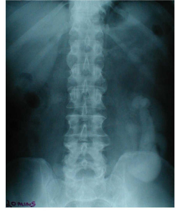

In [148]:
# load image
example = test_data["train"][0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [149]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

axial ct scan showing a large mass of the right kidney.


In [150]:
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x708>,
 'Unnamed: 0': 7863,
 'id': 'ROCO_78739',
 'caption': ' 20-minute film of intravenous urography shows crossed, fused renal ectopia in the left ilio-lumbar region.\n'}

In [145]:
train_dataset[0]

{'input_ids': tensor([  101,  7978,  2203, 19137,  3630, 14773,  3746,  1006,  1021,  1012,
          1019, 11413,  1007,  1997,  1996,  2168,  1006, 20965,  1012,  1017,
          1007,  5776,  1012,  1044, 22571,  8913,  9905,  2594,  3742, 17657,
          1996,  6829,  4181,  2819,  1012, 11792,  1044, 22571,  8913,  9905,
          2594,  3164,  1048, 24335,  8458, 14164,  2024,  2036,  2556,  1012,
          2482, 21081,  2863,  1997,  1996, 23713, 22187,  1997, 12436,  3334,
          1024,  1056,  2509,  2078,  2487,  1012,  1006, 21469,  1024,  6829,
          4181,  2389, 11320,  3549,  1010,  1056,  1024, 10722, 20360,  3742,
          1010,  1048,  2078,  1024, 18804, 16677,  1048, 24335,  8458, 14164,
          1007,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [143]:
example = test_dataset[0]



tensor([[[1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         ...,
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303]],

        [[2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         ...,
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749]],

        [[2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
         [2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
         [2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

In [ ]:
from os import listdir
from keras.applications.vgg16 import preprocess_input

def load_photos(directory):
	images = dict()
	for name in listdir(directory):
		# load an image from file
		filename = directory + '/' + name
		image = load_img(filename, target_size=(400, 600))
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		# reshape data for the model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the VGG model
		image = preprocess_input(image)
		# get image id
		image_id = name.split('.')[0]
		images[image_id] = image
	return images

# load images
images = load_photos(image_folder)
print('Loaded Images: %d' % len(images))

In [ ]:
from keras.applications.vgg16 import VGG16
# load the model
in_layer = tf.keras.Input(shape=(400, 600, 3))
model = VGG16(include_top=False, input_tensor=in_layer, pooling='avg')
# print(model.summary())